# Demo ARIMA, Prophet Time Series Forecasting on Anyscale

In [1]:
# install open-source ray if you haven't already
# !pip install "ray[default] installs the latest version; otherwise use a specific version
# !pip install "ray[default]==1.8.0"

In [2]:
###########
# Import libraries
###########

# Open-source libraries
from typing import List   # Python types
import time               # Python time functions
import ray                # Run distributed code
import numpy as np        # Numerical processing
import pandas as pd       # Dataframe (tabular data) processing
import matplotlib as mpl  # Graph plotting
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

# Open-source ARIMA forecasting libraries
import warnings
warnings.filterwarnings('ignore')
arima_model_type = "pmdarima.arima.arima.ARIMA"
import pmdarima as pm
from pmdarima.model_selection import train_test_split

# Open-source Prophet forecasting libraries
# Note: using kats since it looks more actively maintained than original prophet
import kats
from kats.consts import TimeSeriesData
from kats.models.prophet import ProphetModel, ProphetParams

!python --version
print(f"ray: {ray.__version__}")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"matplotlib: {mpl.__version__}")
print(f"pmdarima: {pm.__version__}")

Python 3.8.12
ray: 1.8.0
numpy: 1.20.3
pandas: 1.3.4
matplotlib: 3.4.3
pmdarima: 1.8.3


In [3]:
# ###########
# # start-up ray on your laptop for testing purposes
# ###########

# NUM_CPU = 8
# ray.shutdown()  #in case a different ray server is already running

# ray.init(
#     ignore_reinit_error=True
#     , num_cpus = NUM_CPU
# )

In [4]:
###########
# connect to Anyscale cluster
###########

# You can specify more pip installs, clone github, or copy code/data into runtime env.
# https://docs.anyscale.com/user-guide/configure/dependency-management/cluster-and-runtime-environments
my_env={"working_dir": "."}

ray.init(
    "anyscale://running-forecast"
    , runtime_env=my_env
    , cluster_env="christy-forecast:3")


(anyscale +0.3s) .anyscale.yaml found in project_dir. Directory is attached to a project.
(anyscale +0.5s) Using project (name: christy_workspace, project_dir: /Users/christy/Documents/AnyscaleDemos/forecasting_demos/anyscale_testing, id: prj_5EhHxe6G4zLUqxm84t8PfByX).
(anyscale +1.4s) cluster running-forecast is currently running, the cluster will not be restarted.
(anyscale +11.8s) Connected to running-forecast, see: https://beta.anyscale.com/projects/prj_5EhHxe6G4zLUqxm84t8PfByX/clusters/ses_p1WvYJCF3SrxyuyXT8A7R4VJ
(anyscale +11.8s) URL for head node of cluster: https://dashboard-ses-p1wvyjcf3srxyuyxt8a7r4vj.anyscale-internal-hsrczdm-0000.anyscale-test-production.com


AnyscaleClientContext(dashboard_url='https://dashboard-ses-p1wvyjcf3srxyuyxt8a7r4vj.anyscale-internal-hsrczdm-0000.anyscale-test-production.com/dashboard?token=bc87e9bc-5314-4800-8f22-5a6675324668', python_version='3.8.5', ray_version='1.8.0', ray_commit='72fdf3be605e4aadfd9a8c3f01dd7843c01cb8fd', protocol_version='2021-09-22', _num_clients=1, _context_to_restore=None)

# Read 8 months clean NYC taxi data 
Normally there is a data cleaning/prep step here to convert raw data -> cleaned data.  We'll dig into details of ETL later.  For now, let's just start with cleaned data...

In [5]:
###########
# Read pandas dataframe
###########
# read 8 months of clean, aggregated monthly taxi data
filename = "../data/clean_taxi_monthly.parquet"
g_month = pd.read_parquet(filename) 

# rename "time" column, since prophet expects that, arima doesn't care
g_month.reset_index(inplace=True)
g_month.rename(columns={'pickup_monthly':'time'}, inplace=True)

display(g_month.head())

# Train a model per item_id
item_list = list(g_month['pulocationid'].unique())


,time,pulocationid,trip_quantity,pickup_lat,pickup_lon
0,2019-07-31,1,50,40.689514,-74.176788
1,2019-07-31,10,2201,40.678123,-73.791664
2,2019-07-31,100,138614,40.753513,-73.988785
3,2019-07-31,101,63,40.743721,-73.709068
4,2019-07-31,102,97,40.702679,-73.881996


In [6]:
###########
# Assume this is already-existing code.
# Each algorithm's train and inference are in separate functions
# Also assume you have a Algorithm driver function that can iterate through a list of algorithms
###########


###########
# ARIMA train_model function, default train on 6 months, inference 2
###########
def train_model_ARIMA(input_data:pd.DataFrame
                , item_col:str
                , item_value:str, target_col:str
                , train_size:int=6) -> list:
    
    
    import warnings
    warnings.filterwarnings('ignore')

    # split data into train/test
    train, test = train_test_split(input_data.loc[(input_data[item_col]==item_value), :]
                                   , train_size=train_size)
    
    # train and fit auto.arima model
    model = pm.auto_arima(y=train[target_col]
                          # all X variables are constants here, so they don't really help
                          # ,X=train.loc[:, (train.columns!=target_col) 
                          #                 & (train.columns!=item_col)]
                         )
    
    # here is the extra pickle step to handle arima's statsmodel objects
    return [train, test, pickle.dumps(model)]


###########
# ARIMA inference_model function
###########
def inference_model_ARIMA(model_pickle:bytes
                          , test:pd.DataFrame
                          , item_col:str
                          , target_col:str) -> pd.DataFrame:

    # unpickle the model - only need this for statsmodel objects
    model = pickle.loads(model_pickle)
    
    # ARIMA inference on test data
    forecast = pd.DataFrame(model.predict(n_periods=test.shape[0]
                         , X=test.loc[:, (test.columns!=target_col) & (test.columns!=item_col)]
                         , index=test.index))
    
    # put both actual_value and predicted_value in forecast, for easier eval later
    forecast.columns = ['fcst_arima']
    forecast.fcst_arima = forecast.fcst_arima.astype(np.int32)   
    forecast = pd.concat([forecast
                         , test.loc[:, target_col].reset_index()]
                         , axis=1)
    forecast.set_index('time', inplace=True)
    
    return forecast


###########
# Prophet train_model function, default train on 6 months, inference 2
###########
def train_model_PROPHET(theDF:pd.DataFrame
                , item_col:str
                , item_value:str, target_col:str
                , train_size:int=6) -> list:
    
    import warnings
    warnings.filterwarnings('ignore')

    # split data into train/test
    train, test = train_test_split(theDF.loc[(theDF[item_col]==item_value), :], train_size=train_size)
    
    # convert pandas df to TimeSeriesData(df), with "time" column and any number of value columns.
    train_ts = TimeSeriesData(train[["time", target_col]])
    test_ts = TimeSeriesData(test[["time", target_col]])
    
    # create a prophet model param instance
    params = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

    # create a prophet model instance
    model = ProphetModel(train_ts, params)
    
    # fit model simply by calling m.fit()
    model.fit()

    # index train, test by time
    train.set_index('time', inplace=True)
    test.set_index('time', inplace=True)
    return [train, test, model]


###########
# Prophet inference_model function
###########
def inference_model_PROPHET(model:'kats.models.prophet.ProphetModel'
                            , test:pd.DataFrame
                            , item_col:str
                            , target_col:str) -> pd.DataFrame:
    
    import warnings
    warnings.filterwarnings('ignore')
    
    # Prophet inference on test data
    forecast = model.predict(steps=test.shape[0], freq="MS")

    # put both actual_value and predicted_value in forecast, for easier eval later
    forecast.fcst = forecast.fcst.astype(np.int32)
    forecast.fcst_lower = forecast.fcst_lower.astype(np.int32)
    forecast.fcst_upper = forecast.fcst_upper.astype(np.int32)
    forecast.columns = ['time', 'fcst_prophet', 'fcst_prophet_lower', 'fcst_prophet_upper']
    forecast = pd.concat([forecast
                         , test.loc[:, target_col].reset_index(drop=True)]
                         , axis=1)
    forecast.set_index('time', inplace=True)
    
    return forecast


###########
# Generic algorithm handler function that can iterate through a list of algorithms
###########
def handle_algorithms(theDF:pd.DataFrame, algo_name:str, item_list:List[str])->List:
    train = []
    test = []
    model = []
    forecast = []
    algorithm_index = ALGORITHMS.index(algo_name)
    input_data = theDF.copy()
    
    # ARIMA expects input pandas dataframe, indexed by time
    if algo_name == "ARIMA":
        input_data.set_index('time', inplace=True)
    
    start = time.time()
    # train model using chosen algorithm 
    for p,v in enumerate(item_list):
        
            # train, fit model using algorithm choice
            temp_train, temp_test, temp_model = \
                TRAIN_FUNCTIONS[algorithm_index](input_data
                                   , item_col='pulocationid', item_value=v
                                   , target_col='trip_quantity', train_size=6)
            train.append(temp_train)
            test.append(temp_test)
            model.append(temp_model)
            
            # inference model using test data
            forecast.append(
                INFERENCE_FUNCTIONS[algorithm_index](model[p]
                                , test[p]
                                , item_col='pulocationid'
                                , target_col='trip_quantity'))
            
    total_time = time.time()-start
    return [train, test, model, forecast, total_time]

In [7]:
###########
# Generic algorithm handler function that can iterate through a list of algorithms
# Modified for calling ray remote functions
###########
def handle_algorithms_ray(theDF:pd.DataFrame, algo_name:str, item_list:List[str])->List:
    train_obj_refs = []
    test_obj_refs = []
    model_obj_refs = []
    forecast_obj_refs = []
    algorithm_index = ALGORITHMS.index(algo_name)
    input_data = theDF.copy()
    
    # ARIMA expects input pandas dataframe, indexed by time
    if algo_name == "ARIMA":
        input_data.set_index('time', inplace=True)
    
    start = time.time()
    # train model using chosen algorithm 
    for p,v in enumerate(item_list):
        
            # train, fit model using algorithm choice
            temp_train, temp_test, temp_model = \
                TRAIN_FUNCTIONS_RAY[algorithm_index].remote(input_data
                                   , item_col='pulocationid', item_value=v
                                   , target_col='trip_quantity', train_size=6)
            train_obj_refs.append(temp_train)
            test_obj_refs.append(temp_test)
            model_obj_refs.append(temp_model)
            
            # inference model using test data
            forecast_obj_refs.append(
                INFERENCE_FUNCTIONS_RAY[algorithm_index].remote(model_obj_refs[p]
                                , test_obj_refs[p]
                                , item_col='pulocationid'
                                , target_col='trip_quantity'))
            
    # ray blocking step, to get the forecasts
    forecast = ray.get(forecast_obj_refs)
            
    total_time = time.time()-start
    return [forecast, total_time]

In [ ]:
%%capture cap 
# above: ipython cell magic to capture cell output to file

###########
# Main program flow to train and inference List of Algorithms
###########

# Define list of Algorithms you want to run
ALGORITHMS = ["ARIMA", "PROPHET"]

# Define list of function names per algorithm
TRAIN_FUNCTIONS = [train_model_ARIMA, train_model_PROPHET]
INFERENCE_FUNCTIONS = [inference_model_ARIMA, inference_model_PROPHET]

# Convert your previously-defined regular python functions to ray parallelized functions
train_model_ARIMA_remote = ray.remote(train_model_ARIMA).options(num_returns=3)
inference_model_ARIMA_remote = ray.remote(inference_model_ARIMA)
train_model_PROPHET_remote = ray.remote(train_model_PROPHET).options(num_returns=3)
inference_model_PROPHET_remote = ray.remote(inference_model_PROPHET)

# Define list of parallelized function names per algorithm
TRAIN_FUNCTIONS_RAY = [train_model_ARIMA_remote, train_model_PROPHET_remote]
INFERENCE_FUNCTIONS_RAY = [inference_model_ARIMA_remote, inference_model_PROPHET_remote]

# Toggle on/off if you want to run regular Python
REGULAR_PYTHON = True
# Toggle on/off if you want to run Ray
USE_RAY = True

trains = []
tests = []
models = []
forecasts = []
forecasts_ray = []
total_times = []

for algo_name in ALGORITHMS:
    
    # Check if you want to run Regular Python version of algorithms
    if REGULAR_PYTHON:
        print()
        print('###########')
        print("# Starting Regular Python main program flow...")
        print('###########')
        # for each algorithm, train and inference a model
        train, test, model, forecast, total_time = handle_algorithms(g_month, algo_name, item_list)
        # keep train and inference artifacts for later
        trains.append(train)
        tests.append(test)
        models.append(model)
        forecasts.append(forecast)
        total_times.append(total_time)
        print(f"Done! {algo_name} training and forecasting on Regular Python finished in {total_time} seconds")
    

    # Check if you want to run parallel version of algorithms
    if USE_RAY:
        print()
        print('###########')
        print("# Starting Ray main program flow...")
        print('###########')
        # for each algorithm, train and inference a model
        forecast, total_time = handle_algorithms_ray(g_month, algo_name, item_list)
        # keep forecast artifacts for later
        total_times.append(total_time)
        forecasts_ray.append(forecast)
        print(f"Done! {algo_name} training and forecasting on Ray finished in {total_time} seconds")

In [9]:
#save above cell's output to file
with open('training_logs.html', 'w') as f:
    f.write(cap.stdout)
    
# verify both forecasts are the same
assert len(forecasts) == len(forecasts_ray)
assert forecasts[0][0].equals(forecasts_ray[0][0])
assert forecasts[0][1].equals(forecasts_ray[0][1])

for i,model in enumerate(ALGORITHMS):  #0, 1
    for j,ray in enumerate(["Regular Python", "Ray"]):  #0, 1
        print(f"{model} training and forecasting {ray} finished in {total_times[2*i+j]} seconds")
        # for p,v in enumerate(item_list[0:2]):
        #     display(forecasts[i][p].head(2))
        
# Ray local results
# ARIMA training and forecasting Regular Python finished in 18.422557830810547 seconds
# ARIMA training and forecasting Ray finished in 5.575595855712891 seconds
# PROPHET training and forecasting Regular Python finished in 184.06618189811707 seconds
# PROPHET training and forecasting Ray finished in 45.37915086746216 seconds

# Note: size of data and runtime is small; so expected to get corresponding speed-up running on clusters.

ARIMA training and forecasting Regular Python finished in 17.29460906982422 seconds
ARIMA training and forecasting Ray finished in 22.546693086624146 seconds
PROPHET training and forecasting Regular Python finished in 181.4179458618164 seconds
PROPHET training and forecasting Ray finished in 59.92982506752014 seconds


In [10]:
###########
# Assemble all the forecasts in one big df, for easier model comparison
###########

all_the_forecasts = []        
for p,v in enumerate(item_list[0:2]):

    # assemble ARIMA forecasts and put item_id back in
    if 'ARIMA' in ALGORITHMS:
        algorithm_index = ALGORITHMS.index('ARIMA')
        temp_arima = forecasts[algorithm_index][p] \
            .reset_index() \
            .copy()
        temp_arima['pulocationid'] = v
        temp_arima = temp_arima.reindex(['time', 'pulocationid', 'trip_quantity', 'fcst_arima'], axis=1)

    # assemble PROPHET forecasts
    if 'PROPHET' in ALGORITHMS:
        algorithm_index = ALGORITHMS.index('PROPHET')
        temp_prophet = forecasts[algorithm_index][p] \
            .reset_index() \
            .drop(["time", "trip_quantity"], axis=1) \
            .copy()
        temp = pd.merge(temp_arima, temp_prophet, left_index=True, right_index=True)

    all_the_forecasts.append(temp)

    
# print(forecasts)
all_the_forecasts = pd.DataFrame(np.concatenate(all_the_forecasts))
all_the_forecasts.columns=['time', 'pulocationid', 'trip_quantity', 'fcst_arima'
                             , 'fcst_prophet', 'fcst_prophet_lower'
                             , 'fcst_prophet_upper']
all_the_forecasts.head()

,time,pulocationid,trip_quantity,fcst_arima,fcst_prophet,fcst_prophet_lower,fcst_prophet_upper
0,2020-01-31,1,34,45,49,44,54
1,2020-02-29,1,35,51,49,43,54
2,2020-01-31,10,1689,2003,1859,1722,1982
3,2020-02-29,10,1386,2003,1801,1669,1929


len(forecast): 4


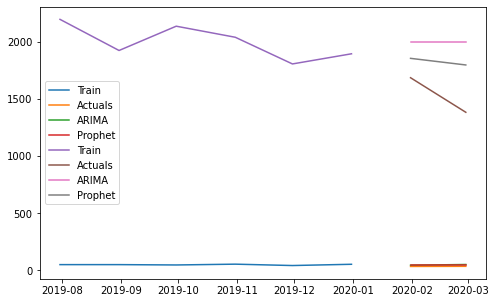

(scheduler +9m52s) Removing 5 nodes of type worker-node-type-0 (idle).


The node with node id: b34939211e51c8920f459b47b7e66cd29dff6383d487ad14310b1a99 and ip: 10.0.22.20 has been marked dead because the detector has missed too many heartbeats from it. This can happen when a raylet crashes unexpectedly or has lagging heartbeats.
The node with node id: 035a5e417f546bd0aec05ec93eee5c9f64f61f77472dc52469625fa8 and ip: 10.0.27.154 has been marked dead because the detector has missed too many heartbeats from it. This can happen when a raylet crashes unexpectedly or has lagging heartbeats.
The node with node id: aaba5f1dc3ffdf75f9e9e43a8ec4c3df6a1d120f94a21483de1831bd and ip: 10.0.17.18 has been marked dead because the detector has missed too many heartbeats from it. This can happen when a raylet crashes unexpectedly or has lagging heartbeats.
The node with node id: 0f3e8cf1f4289de70fd510d78b5b2897c17a620289346dbb14515287 and ip: 10.0.28.114 has been marked dead because the detector has missed too many heartbeats from it. This can happen when a raylet crashes un

(scheduler +10m51s) Resized to 72 CPUs.
(scheduler +10m56s) Resized to 8 CPUs.


In [11]:
###########
# inspect a few forecasts
###########

# assert len(all_the_forecasts) == len(item_list)
print(f"len(forecast): {len(all_the_forecasts)}")

# eyeball first two forecasts
plt.figure(figsize=(8,5))
for p,v in enumerate(item_list[0:2]):
    item_forecast = all_the_forecasts.loc[(all_the_forecasts.pulocationid==v), :].copy()
    item_forecast.set_index("time", inplace=True)
    # display(item_forecast)    
    
    # plot train, test actuals, and forecasts
    plt.plot(trains[0][p]['trip_quantity'], label="Train")
    plt.plot(tests[0][p]['trip_quantity'], label="Actuals")
    plt.plot(item_forecast["fcst_arima"], label="ARIMA")
    plt.plot(item_forecast["fcst_prophet"], label="Prophet")
    plt.legend(loc='best')